In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, TensorDataset
from transformers import DistilBertTokenizer, AutoModelForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from torch.utils.data import Dataset
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments, Trainer, AutoTokenizer
from datasets import Dataset
import evaluate


### Setup the GPU
- **CUDA Compatibility:** The code first checks if CUDA is available on your machine. CUDA is a parallel computing platform and API model created by Nvidia. It allows software developers to use a CUDA-enabled graphics processing unit (GPU) for general purpose processing (an approach termed GPGPU, General-Purpose computing on Graphics Processing Units).

- **Device Selection:** Based on the availability of CUDA, the code sets the `device` variable to either 'cuda' or 'cpu'. If a compatible Nvidia GPU is available, it will select 'cuda', which means PyTorch will perform tensor computations on the GPU. If not, it defaults to 'cpu', meaning computations will be performed on the CPU.

- **Performance Implications:** Training models on GPUs is typically much faster than on CPUs, especially for tasks like training large neural networks in NLP. Therefore, this code is crucial for performance optimization.

This approach is a standard best practice in PyTorch for device-agnostic coding. It allows your code to automatically use GPU resources if available, improving performance, but still run on a CPU if a GPU is not available.

In [37]:
from torch import cuda  # Importing the cuda module from PyTorch to interact with CUDA-enabled GPUs
# Setting up the device for computation
device = torch.device('cuda' if cuda.is_available() else 'cpu')
# This line checks if CUDA (NVIDIA GPU support) is available.
# If CUDA is available, it sets the device to 'cuda' (i.e., use the GPU).
# If CUDA is not available, it falls back to using the CPU ('cpu').

print(f"Current device: {device}")  # Printing the device that will be used for computations

Current device: cuda


### Loading the Dataset
- **Utilizing Pandas for Data Loading**: We chose Pandas for this task because of its efficiency and ease of use in handling large datasets. By using the `read_csv` function, we were able to quickly load the dataset from a CSV file into a DataFrame. 

- **Dataset Source**: The dataset, sourced from Kaggle, contains various comments labeled for toxicity and other attributes. The file path `'/kaggle/input/toxic-data/train.csv'` indicates that the data is stored in a specific directory on Kaggle, a common practice for datasets used in Kaggle competitions.

- **Assignment to `train_df`**: We assigned the loaded data to the variable `train_df`, a standard naming convention where 'df' stands for DataFrame. This variable now holds all the data from the 'train.csv' file, ready for the next steps in my project.

In [38]:
# Loading the training dataset using Pandas
train_df = pd.read_csv('toxic-comments-files\\train.csv')

### Previewing the Dataset

- **Understanding the DataFrame Structure**: By invoking the `.head()` method on our DataFrame `train_df`, we displayed the first five rows of our dataset. This action is a standard practice in data analysis, giving us a quick snapshot of the data, including column headers and some initial values.

- **Initial Observations**: From this output, we can start to observe the structure of the data, such as the different columns available and the type of information each column contains. It's also our first glimpse at the actual content of the comments and their associated labels, which is crucial for our NLP task.

In [39]:
# Displaying the first few rows of the dataset
train_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [130]:
file_path = 'toxic-comments-files\\train.csv'  # Adjust the file path if needed
df = pd.read_csv(file_path)

sample_df = df.sample(frac=0.1, random_state=1)  # random_state for reproducibility

print(sample_df.columns)

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')


In [131]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

# Tokenization and cleaning
tokens = nltk.word_tokenize(' '.join(sample_df['comment_text']).lower())
tokens = [t for t in tokens if t not in string.punctuation and t not in stopwords.words('english')]

# Counting words
word_freq = Counter(tokens)
print(word_freq.most_common(10))  # Adjust the number to show more/less common words


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Desktop\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[("''", 24426), ('``', 15886), ("'s", 6937), ("n't", 6111), ('article', 5806), ('wikipedia', 4616), ('page', 4486), ('talk', 3454), ('would', 3120), ('please', 2905)]


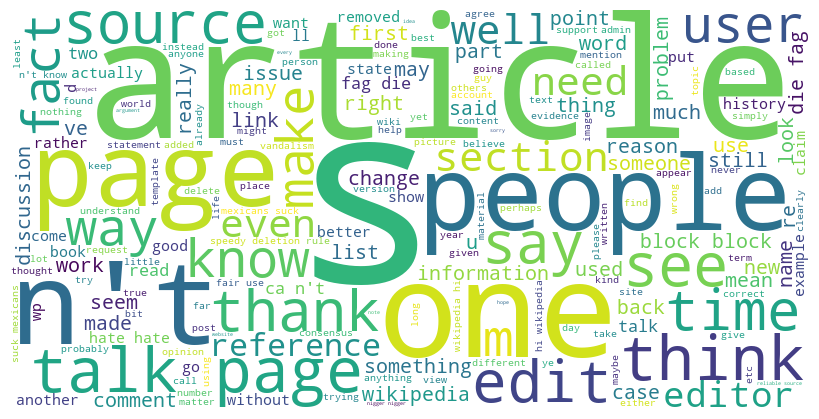

In [132]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generating a word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(tokens))

# Plotting the WordCloud image
plt.figure(figsize=(8, 8), facecolor=None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad=0) 
plt.show()

In [40]:
# Assuming train_df still contains all the comments and original labels
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Initialize the 'label' column as 'non-toxic'
train_df['labels'] = 'non-toxic'

# Loop through the columns and update the 'label' based on the condition
for label in labels:
    condition = train_df[label] == 1
    train_df.loc[condition, 'labels'] = 'toxic'

# Drop unnecessary columns
train_df.drop(labels, axis=1, inplace=True)


In [41]:
# Rename the 'comment_text' column to 'text' for clarity or to match the input requirements of later processing
# 'inplace=True' makes the change in the original DataFrame without the need to assign it to a new DataFrame
train_df.rename(columns={"comment_text": "text"}, inplace=True)


In [42]:
train_df.head()

,id,text,labels
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,non-toxic
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,non-toxic
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",non-toxic
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",non-toxic
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",non-toxic


In [43]:
# Display the statistical summary of the DataFrame
train_df.describe()

,id,text,labels
count,159571,159571,159571
unique,159571,159571,2
top,0000997932d777bf,Explanation\nWhy the edits made under my usern...,non-toxic
freq,1,1,143346


In [44]:
train_df['labels'].value_counts()

labels
non-toxic    143346
toxic         16225
Name: count, dtype: int64

## Preprocessing: Label Encoding

In this section, we perform label encoding for our dataset. Label encoding is a process of converting categorical textual labels into numerical form. This transformation is necessary because machine learning models typically require input to be in numerical format.

We define two dictionaries: `id2label` and `label2id`. The `id2label` dictionary maps numerical IDs to their corresponding textual labels (e.g., {0: "non-toxic", 1: "toxic"}), which is useful for interpreting the model's predictions. Conversely, `label2id` maps textual labels to numerical IDs (e.g., {'non-toxic': 0, 'toxic': 1}), which we use to transform our dataset's labels into a format suitable for model training.

The transformation is applied to the `labels` column of our DataFrame, converting each textual label into its corresponding numerical ID.

In [45]:
# Define two dictionaries for label conversion: one for converting IDs to labels (id2label),
# and one for converting labels to IDs (label2id).
id2label = {0: "non-toxic", 1: "toxic"}
label2id = {'non-toxic':0,'toxic':1}

# Convert the 'labels' column in the DataFrame from textual labels to numerical IDs.
# This is done using the 'apply' method, which applies a lambda function to each element in the column.
# The lambda function uses the label2id dictionary to convert each textual label to its corresponding numerical ID.
train_df["labels"] = train_df["labels"].apply(lambda x: label2id[x])

## Balancing the Dataset

In the dataset, different labels might have different numbers of samples, leading to a class imbalance. To address this, we balance the dataset by ensuring each class has an equal number of samples.

First, we find the minimum number of samples present in any class. We then create a new DataFrame, `sampled_df`, where we sample this number of instances from each class. This is achieved using the `groupby` method (grouping data by labels) followed by `apply` (applying a sampling function to each group). The result is a balanced dataset where each class is equally represented, mitigating potential biases during model training.

Finally, we verify the balancing by counting the occurrences of each label in `sampled_df`, ensuring that each label has the same number of samples.

In [46]:

# Calculate the minimum number of samples any label has in the dataset
# This is done by counting the occurrences of each label and then finding the minimum count
min_label_count = train_df['labels'].value_counts().min()

# Create a balanced dataset
# The 'groupby' method is used to group the data by labels
# Then, 'apply' method is used to apply a lambda function to each group
# The lambda function samples 'min_label_count' number of samples from each group
# This ensures each label has the same number of samples in the new DataFrame
# 'reset_index(drop=True)' resets the index of the new DataFrame and drops the old index
sampled_df = train_df.groupby('labels').apply(lambda x: x.sample(min_label_count)).reset_index(drop=True)

# Display the count of each label in the new balanced DataFrame
# This is to verify that each label now has the same number of samples
sampled_df['labels'].value_counts()

labels
0    16225
1    16225
Name: count, dtype: int64

## Analyzing Text Length in the Dataset

In Natural Language Processing tasks, understanding the length of text data is crucial as it can impact the choice of preprocessing steps and the design of neural network models.

To gain insights into our dataset, we calculate the average length of the text in the `text` column of our DataFrame, `train_df`. This step involves:

1. **Calculating Lengths**: We determine the length (number of characters) of each text entry in the dataset.
2. **Computing the Average**: We then calculate the mean of these lengths to understand the typical size of text entries in our dataset.

The average text length is printed out, providing valuable information for decisions regarding text preprocessing, such as setting the maximum sequence length for tokenization.

In [47]:
# Calculate the length of each text entry in the 'text' column of train_df
# The 'apply' function is used to apply a lambda function to each row in the 'text' column
# The lambda function converts each entry to a string (in case there are non-string types) and calculates its length
lengths = train_df['text'].apply(lambda x: len(str(x)))

# Calculate the average length of the text entries
# The 'mean' function calculates the average value of the lengths calculated above
average_length = lengths.mean()

# Print the average length
# This gives an idea of the typical size of the text entries in your dataset
print(f"The average length of the column is: {average_length}")

The average length of the column is: 394.0732213246768


## Conversion to Hugging Face Dataset

To efficiently handle our preprocessed text data within the Hugging Face ecosystem, we convert our balanced pandas DataFrame `sampled_df` into a `Dataset` object using the `datasets` library.

### Why Convert to a `Dataset` Object?
The `Dataset` class from the `datasets` library offers several advantages, especially for NLP tasks:

1. **Efficient Memory Usage**: The `Dataset` class is designed to be memory-efficient, which is crucial when working with large text data.
2. **Easy Integration**: It integrates seamlessly with the `transformers` library, making it easier to preprocess the data for model training.
3. **Advanced Features**: It supports features like map, filter, and shuffle, which are useful for data manipulation and preparation before training.

By converting our DataFrame to a `Dataset`, we ensure that our data is in the optimal format for further processing and model training in the Hugging Face environment.

In [48]:
# Convert the pandas DataFrame 'sampled_df' into a Dataset object
# The Dataset object is more optimized for NLP tasks and works well with transformers and related pipelines
ds = Dataset.from_pandas(sampled_df)

In [49]:
ds

Dataset({
    features: ['id', 'text', 'labels'],
    num_rows: 32450
})

## Selection of Pre-Trained Model

For our NLP task, we have chosen to use the `distilbert-base-uncased` model from Hugging Face's Transformers library. DistilBERT is a smaller, lighter, and faster version of BERT (Bidirectional Encoder Representations from Transformers) while retaining most of its performance.

### Why DistilBERT?
- **Efficiency**: DistilBERT is designed to be more efficient than BERT, allowing for faster training and inference times, which is beneficial for practical applications and when computational resources are limited.
- **Performance**: Despite its smaller size, DistilBERT retains a significant proportion of BERT's performance, making it a suitable choice for many NLP tasks.
- **Uncased Model**: The 'uncased' variant treats upper and lower case letters as the same, reducing the complexity of the model and often improving its generalization capabilities.

Using this pre-trained model, we aim to leverage transfer learning, where the model has already learned a wide range of language representations from a large text corpus, and we fine-tune it for our specific task.

In [50]:
# Define the pre-trained model to be used
# 'distilbert-base-uncased' is a smaller, faster, and lighter version of BERT
# 'uncased' means the model does not make a distinction between upper and lower case
pretrained_model = 'distilbert-base-uncased'

## Initializing the Tokenizer

To preprocess our text data for the `distilbert-base-uncased` model, we initialize a tokenizer using Hugging Face's `AutoTokenizer` class. The tokenizer is a critical component in the NLP pipeline, as it converts raw text into a format understandable by the model.

### Role of the Tokenizer
- **Tokenization**: Breaks down text into tokens (words, subwords, or characters).
- **Encoding**: Maps each token to an integer ID understood by the model.
- **Preprocessing**: Applies necessary preprocessing like lowercasing (for uncased models), padding, and truncation.

We specifically use a fast tokenizer (`use_fast=True`), which is an optimized implementation, offering speed and efficiency improvements. This tokenizer aligns with our chosen `distilbert-base-uncased` model, ensuring compatibility and optimal performance for our text data.

In [51]:
# Initialize the tokenizer for the specified pre-trained model
# The tokenizer is responsible for converting raw text into a format that's suitable for the model
# 'use_fast=True' enables the use of the fast tokenizer which is more efficient
tokenizer = AutoTokenizer.from_pretrained(pretrained_model, use_fast =True)

## Text Preprocessing Function

To prepare our dataset for training with the DistilBERT model, we define a preprocessing function called `preprocess`. This function uses the previously initialized tokenizer to convert raw text into a format that's suitable for the model.

### Details of the Preprocess Function
- **Input**: The function expects a dictionary with a key `'text'`, where the value is the raw text to be tokenized.
- **Tokenization**: It applies the tokenizer to the text, which involves converting words into tokens and mapping these tokens to their respective IDs as understood by the model.
- **Truncation and Padding**: The function ensures that all tokenized inputs are of a uniform length (maximum of 256 tokens). Texts longer than 256 tokens are truncated, and shorter texts are padded.
- **Output**: The output is a dictionary containing `input_ids` (token IDs) and `attention_mask` (masking tokens to indicate which tokens should be attended to by the model).

This preprocessing step is crucial for transforming textual data into a numerical format that can be processed by our neural network model, ensuring consistency in input size and format.


In [52]:
def preprocess(x):
    # Tokenize the input text.
    # 'truncation=True' ensures that texts longer than the model's maximum length are truncated.
    # 'max_length=256' sets the maximum length of the tokens. This length can be adjusted based on requirements.
    return tokenizer(x["text"], truncation=True, max_length=256)

## Applying Tokenization to the Dataset

With our `preprocess` function defined, we now apply it to our entire dataset. This step is crucial for transforming all the textual data into a format suitable for our DistilBERT model.

### Process Overview
- We use the `map` method from the Hugging Face `datasets` library. This method efficiently applies the `preprocess` function to each element in our dataset.
- By setting `batched=True`, we ensure that the function is applied to batches of the dataset instead of one item at a time. This batching significantly speeds up the process, especially for larger datasets.

### Post-Tokenization Dataset
- After tokenization, our dataset, now referred to as `tok_ds`, contains several new columns, such as `input_ids` and `attention_mask`, which are generated by the tokenizer.
- `input_ids` are the token IDs representing each token in the texts.
- `attention_mask` indicates to the model which parts of the tokenized text should be focused on and which parts are paddings.

This transformation is a key step in preparing our data for model training, ensuring that it's in the exact format expected by the neural network model.


In [53]:
# Apply the preprocess function to the entire dataset
# 'batched=True' processes the data in batches, which is more efficient for larger datasets
tok_ds = ds.map(preprocess, batched=True)

# Display the processed dataset
# This shows the structure of the dataset after tokenization, including the new keys added by the tokenizer
tok_ds

Map:   0%|          | 0/32450 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'text', 'labels', 'input_ids', 'attention_mask'],
    num_rows: 32450
})

## Data Collator for Dynamic Padding

In preparation for training our NLP model, we establish a `DataCollatorWithPadding` object. This object plays a crucial role in ensuring our input data is uniformly shaped for efficient batch processing during model training.

### Role and Functionality of Data Collator
- The data collator utilizes our previously initialized tokenizer for padding purposes.
- It dynamically pads the tokenized inputs to the maximum length found in each batch. This means that all sequences in a batch will have the same length, which is necessary for many transformer-based models like DistilBERT.
- We specify `padding='max_length'` to ensure that padding is applied to all sequences in a batch, making them equal in length.

By using this data collator in our training pipeline, we can feed batches of tokenized text data into our model efficiently, with each batch properly and consistently padded to the required size.

In [54]:
# Create a data collator that will dynamically pad the inputs to the maximum length in each batch
# 'tokenizer=tokenizer' specifies the tokenizer to use for padding
# 'padding='max_length'' ensures that all sequences in a batch are padded to the maximum sequence length
# This is necessary for models that require consistent input shapes, like BERT-based models
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, padding='max_length')

## Splitting the Dataset into Training and Test Sets

To prepare our dataset for training and evaluation, we split it into two distinct sets: a training set and a test set.

### Process and Rationale
- **Splitting**: We use the `train_test_split` method from the Hugging Face `datasets` library, which efficiently splits our dataset.
- **Proportion**: We allocate 30% of our data to the test set (`test_size=0.3`), with the remaining 70% for training. This distribution is a common practice, balancing sufficient training data with an adequate test set for evaluation.
- **Purpose**: The training set is used to train our model, while the test set is kept separate and used later to evaluate the model's performance on unseen data. This approach helps us assess how well our model generalizes to new, unseen examples.

By splitting the dataset, we ensure a robust training process and a reliable evaluation of our model's performance.

In [55]:
# Split the dataset into training and testing sets
# 'test_size=0.3' indicates that 30% of the data will be used for testing, and the rest for training
# This split ensures that we have a separate dataset to evaluate our model's performance
dataset = tok_ds.train_test_split(test_size=0.3)

In [56]:
# Splitting the dataset into training and test sets
tok_train_dataset = dataset["train"]
tok_test_dataset = dataset["test"]

In [57]:
accuracy = evaluate.load("accuracy")

**Report (Markdown):**

In this code, we first import the necessary libraries, including NumPy for numerical operations and the AccuracyMetric from the Transformers library for computing accuracy.

We initialize the accuracy metric using `AccuracyMetric()`.

The `compute_metrics` function is defined to compute metrics during the evaluation of a classification model. It takes the `eval_pred` argument, which is expected to be a tuple containing predictions and labels. Inside the function:

1. We unpack the tuple into two variables, `predictions` and `labels`.

2. Next, we compute the predicted class labels by using NumPy's `argmax` function along axis 1. This assumes that the model's predictions are in the form of probability scores for each class.

3. Finally, we compute the accuracy metric by comparing the predicted labels to the actual labels using the `compute` method of the accuracy metric.

This function is designed to be used when evaluating a model's performance and computing accuracy as the evaluation metric. It can be integrated with the Transformers library's `Trainer` class for model evaluation.

In [58]:
# Define a function to compute metrics during evaluation
def compute_metrics(eval_pred):
    # Unpack the evaluation predictions into predictions and labels
    predictions, labels = eval_pred
        
    # Compute the predicted class labels by taking the argmax along axis 1
    predictions = np.argmax(predictions, axis=1)
    
    # Compute accuracy by comparing predicted labels to actual labels
    return accuracy.compute(predictions=predictions, references=labels)

In [27]:
# Define the model architecture and initialize it with pretrained weights
# - 'pretrained_model' is the name or path of the pretrained model to use.
# - 'num_labels' is set to 2, indicating binary classification (toxic or non-toxic).
# - 'id2label' and 'label2id' are used for mapping label indices to label names and vice versa.
# - 'output_attentions=True' indicates that the model should output attention scores.
model = AutoModelForSequenceClassification.from_pretrained(pretrained_model, num_labels=2, id2label=id2label, label2id=label2id, output_attentions=True)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.

In [28]:
# Define the training arguments for fine-tuning the model
training_args = TrainingArguments(
    output_dir="./results",     # Directory where model checkpoints and logs will be saved
    learning_rate=2e-5,         # Learning rate for optimization
    warmup_ratio=0.1,           # Warmup ratio for learning rate scheduler
    lr_scheduler_type="cosine", # Type of learning rate scheduler (cosine annealing)
    fp16=True,                  # Enable mixed-precision training for faster training
    num_train_epochs=2,         # Number of training epochs
    weight_decay=0.01,          # Weight decay for regularization
)

In [29]:
# Create a Trainer instance for training the model
trainer = Trainer(
    model=model,                       # The model to be trained
    args=training_args,                # Training arguments defined earlier
    train_dataset=tok_train_dataset,   # Training dataset
    eval_dataset=tok_test_dataset,     # Evaluation dataset
    tokenizer=tokenizer,               # Tokenizer for tokenizing input text
    data_collator=data_collator,       # Data collator for padding and batching
    compute_metrics=compute_metrics,   # Function for computing evaluation metrics
)

# Start training the model
trainer.train()

C:\Users\Desktop\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/5680 [00:00<?, ?it/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'loss': 0.4106, 'learning_rate': 1.7500000000000002e-05, 'epoch': 0.18}
{'loss': 0.2518, 'learning_rate': 1.9654470112181837e-05, 'epoch': 0.35}
{'loss': 0.2307, 'learning_rate': 1.8414045237318293e-05, 'epoch': 0.53}
{'loss': 0.2143, 'learning_rate': 1.638540828225898e-05, 'epoch': 0.7}
{'loss': 0.2252, 'learning_rate': 1.376429238123197e-05, 'epoch': 0.88}
{'loss': 0.1914, 'learning_rate': 1.0785816267535146e-05, 'epoch': 1.06}
{'loss': 0.1278, 'learning_rate': 7.733726350083331e-06, 'epoch': 1.23}
{'loss': 0.1304, 'learning_rate': 4.899221702053858e-06, 'epoch': 1.41}
{'loss': 0.133, 'learning_rate': 2.5365624048534666e-06, 'epoch': 1.58}
{'loss': 0.1363, 'learning_rate': 8.73064035168687e-07, 'epoch': 1.76}
{'loss': 0.1205, 'learning_rate': 6.456002072534606e-08, 'epoch': 1.94}
{'train_runtime': 1014.0415, 'train_samples_per_second': 44.801, 'train_steps_per_second': 5.601, 'train_loss': 0.1943107114711278, 'epoch': 2.0}


TrainOutput(global_step=5680, training_loss=0.1943107114711278, metrics={'train_runtime': 1014.0415, 'train_samples_per_second': 44.801, 'train_steps_per_second': 5.601, 'train_loss': 0.1943107114711278, 'epoch': 2.0})

**Visualizations:**


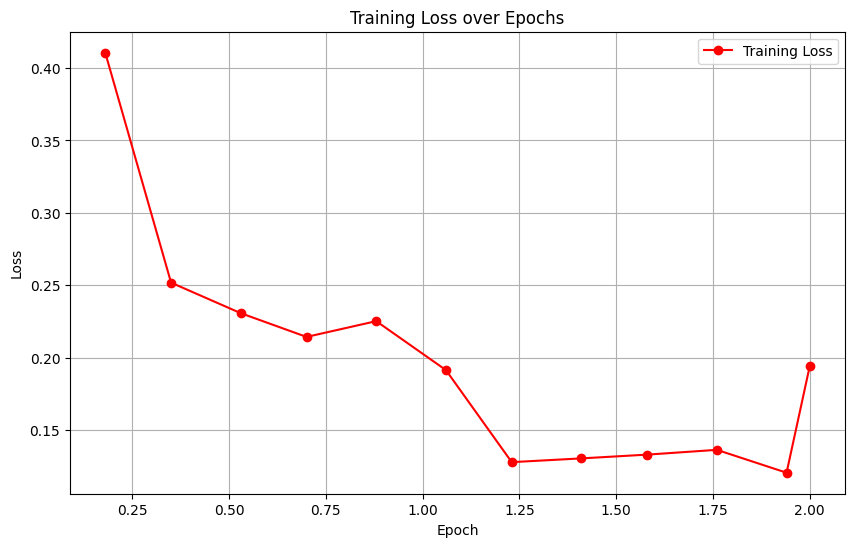

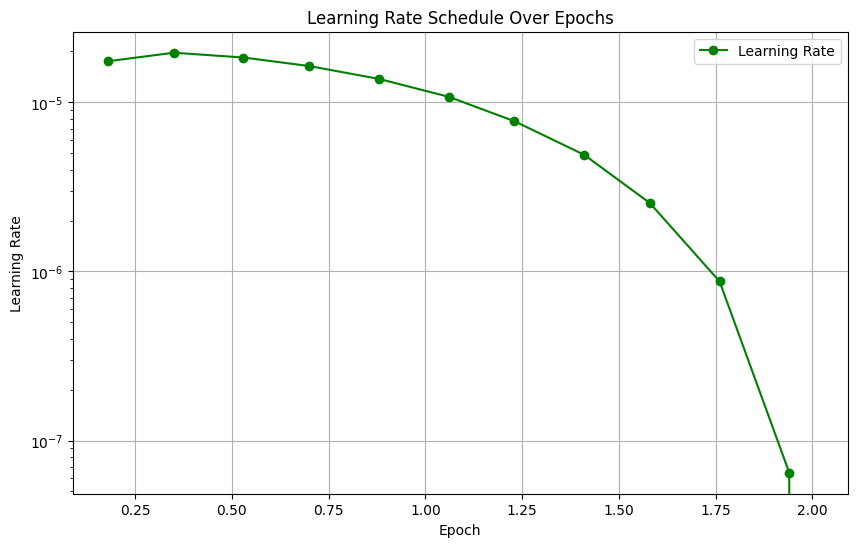

In [133]:
import matplotlib.pyplot as plt
import torch

# Data from your training process
epochs = [0.18, 0.35, 0.53, 0.7, 0.88, 1.06, 1.23, 1.41, 1.58, 1.76, 1.94, 2.0]
loss = [0.4106, 0.2518, 0.2307, 0.2143, 0.2252, 0.1914, 0.1278, 0.1304, 0.133, 0.1363, 0.1205, 0.1943]
learning_rates = [1.750e-05, 1.965e-05, 1.841e-05, 1.639e-05, 1.376e-05, 1.079e-05, 7.734e-06, 4.899e-06, 2.537e-06, 8.731e-07, 6.456e-08, 0]
weights = model.distilbert.transformer.layer[0].ffn.lin1.weight.data.cpu().numpy()

# Create the Training Loss over Epochs plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, marker='o', color='r', label='Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Create the Learning Rate Schedule plot
plt.figure(figsize=(10, 6))
plt.plot(epochs, learning_rates, marker='o', color='g', label='Learning Rate')
plt.title('Learning Rate Schedule Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.yscale('log')  # Log scale for better visibility if learning rates vary widely
plt.legend()
plt.grid(True)
plt.show()

In [96]:
trainer.save_model('toxic_finetuned')

In [64]:
# tok_test = tokenizer(['you are great!'], truncation=True, return_tensors="pt")
tok_test = tokenizer(['you are horrible!'], truncation=True, return_tensors="pt")

In [65]:
tok_test

{'input_ids': tensor([[ 101, 2017, 2024, 9202,  999,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [66]:
# Load the fine-tuned model from the specified path
model = AutoModelForSequenceClassification.from_pretrained("toxic_finetuned")
# Perform inference using the loaded model
with torch.no_grad():
    logits = model(**tok_test).logits

In [67]:
predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'toxic'